# Reddit Project NLP Script
### Reading the dataset

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark.sql.functions as f
from pyspark.sql.functions import col, lit
from pyspark.sql import SparkSession
from pyspark import SparkContext

In [3]:
spark = SparkSession.builder \
        .appName("reddit_nlp") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.4.2") \
    .master('yarn') \
    .getOrCreate()

Ivy Default Cache set to: /home/hadoop/.ivy2/cache
The jars for the packages stored in: /home/hadoop/.ivy2/jars
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a4a25514-c6e1-460f-a9c9-f486a7516a31;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.4.2 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found

In [4]:
spark

In [6]:
df_full = spark.read.parquet('s3://yc910-labdata-3/reddit_eda')

In [7]:
df_full.show(5)

+---------------+--------------+-------------------+---------------+--------------------+---------+----------------+-----------+------+---------+-----------+-----+------------+---------------------+--------+----------+-------+------------+-----+--------+---------+-------+---------------+---------------+
|         author|author_premium|  author_flair_text|author_fullname|                body|collapsed|controversiality|created_utc|gilded|no_follow|quarantined|score|send_replies|total_awards_received|len_body|      date|  month| score_group|covid|election|economics|finance|gender_equality|racial_equality|
+---------------+--------------+-------------------+---------------+--------------------+---------+----------------+-----------+------+---------+-----------+-----+------------+---------------------+--------+----------+-------+------------+-----+--------+---------+-------+---------------+---------------+
|         Lakis9|             0|          left-left|    t2_3dzc316j|We're on literall

In [8]:
df_full.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_premium: integer (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- body: string (nullable = true)
 |-- collapsed: integer (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- no_follow: integer (nullable = true)
 |-- quarantined: integer (nullable = true)
 |-- score: long (nullable = true)
 |-- send_replies: integer (nullable = true)
 |-- total_awards_received: long (nullable = true)
 |-- len_body: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- month: string (nullable = true)
 |-- score_group: string (nullable = true)
 |-- covid: integer (nullable = true)
 |-- election: integer (nullable = true)
 |-- economics: integer (nullable = true)
 |-- finance: integer (nullable = true)
 |-- gender_equality: integer (nullable = true)
 |-- racial_equality: integer (n

## 1. Text Checks / Analysis
### Answer:
Most of the posts are short posts, and those posts shorter than 20 words are more than 50 percent. To get the most common and important words, we will do the text cleaning first. 

In [17]:
df_full.select("len_body").describe().show()

+-------+------------------+
|summary|          len_body|
+-------+------------------+
|  count|           7753637|
|   mean| 22.15030701076153|
| stddev|18.300381640558925|
|    min|                 6|
|    max|               100|
+-------+------------------+



In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

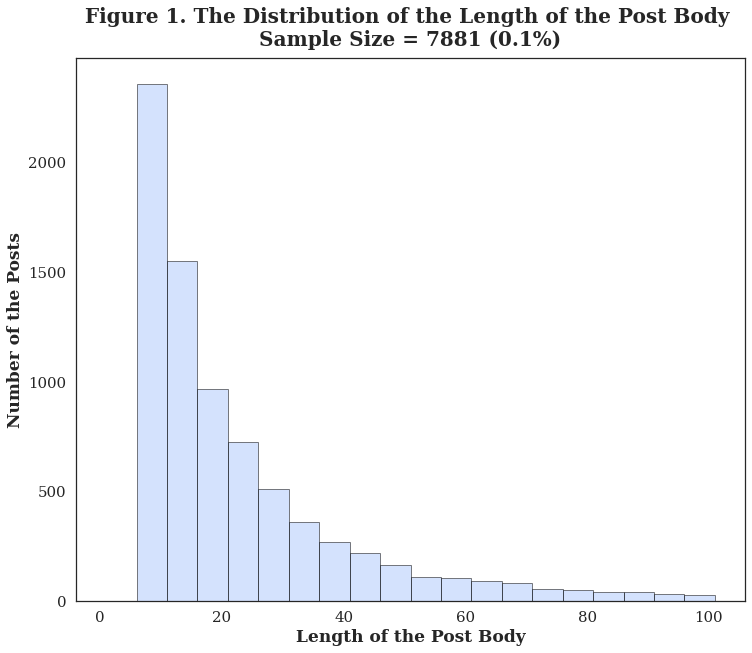

In [19]:
df_small = df_full.sample(fraction=0.001, seed=502).toPandas()
plt.figure(figsize=(12,10))
pal = sns.color_palette(palette="coolwarm", n_colors=2)[1::-1]
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})
plt.hist("len_body", data = df_small, bins = range(1,102,5), edgecolor="black", color=pal[1], alpha=0.5)

### Set a title, axis label, legend and rotate the xticks
plt.title(label="Figure 1. The Distribution of the Length of the Post Body \nSample Size = 7881 (0.1%)", fontsize = 20, fontweight = "bold", y = 1.01)
plt.xlabel(xlabel = "Length of the Post Body", fontsize = 17, fontweight = "bold")
plt.ylabel(ylabel = "Number of the Posts", fontsize = 17, fontweight = "bold")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()

## 2. Clean the Text
### Answer: 
To clean the data, a pipeline was constructed, including cleaning up non-word characters, removing stop words, stemming and lemmatizing. When running a `Stemmer`, a special pattern was recognized that the character `e` at the end of a word was removed, therefore, a `Lemmatizer` was utilized instead of a `Stemmer`, to extract the most important part of a word. And since there are some urls included in the posts, so a regex was firstly applied to remove those urls.

In [11]:
!/mnt/miniconda/bin/pip install sparknlp

In [12]:
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp

In [13]:
empty_df = spark.createDataFrame([['']]).toDF("body")

In [14]:
df_full = df_full.withColumn("body", f.regexp_replace("body", "[\( ](http\S+)[\) ]", " "))

In [15]:
documentAssembler = DocumentAssembler() \
    .setInputCol('body') \
    .setOutputCol('document')

cleanUpPatterns = ["[^a-zA-Z\s]+"]

documentNormalizer = DocumentNormalizer() \
    .setInputCols("document") \
    .setOutputCol("normalizedDocument") \
    .setAction("clean") \
    .setPatterns(cleanUpPatterns) \
    .setReplacement(" ") \
    .setPolicy("pretty_all") \
    .setLowercase(True)

sentenceDetector = SentenceDetector() \
    .setInputCols(["normalizedDocument"]) \
    .setOutputCol("sentence")

Tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("stop_token") \
    .fit(empty_df)
    
stopWordsCleaner = StopWordsCleaner.pretrained() \
    .setInputCols("stop_token") \
    .setOutputCol("stop_body") \
    .setCaseSensitive(False)

stemmer = Stemmer() \
    .setInputCols(["stop_body"]) \
    .setOutputCol("stem_body")

lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(["stop_body"]) \
    .setOutputCol("lemma_body")

tokenAssembler_stem = TokenAssembler() \
    .setInputCols(["sentence", "stem_body"]) \
    .setOutputCol("clean_text")

tokenAssembler_lemma = TokenAssembler() \
    .setInputCols(["sentence", "lemma_body"]) \
    .setOutputCol("clean_text")

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[ | ]stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
Download done! Loading the resource.
[OK!]


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.


[ / ]

[OK!]


In [16]:
cleanPipeline_stem = Pipeline() \
    .setStages([
        documentAssembler,
        documentNormalizer,
        sentenceDetector, 
        Tokenizer, 
        stopWordsCleaner, 
        stemmer,
        tokenAssembler_stem])
df_clean_stem = cleanPipeline_stem.fit(df_full).transform(df_full)

In [17]:
df_clean_stem.select("clean_text").show(5,truncate=False)

22/04/15 20:47:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|clean_text                                                                                                                                                                                                                                                                             |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[[document, 0, 24, liter exact point compass, [sentence -> 0], []]]                                                                                      

In [18]:
cleanPipeline_lemma = Pipeline() \
    .setStages([
        documentAssembler,
        documentNormalizer,
        sentenceDetector, 
        Tokenizer, 
        stopWordsCleaner, 
        lemmatizer,
        tokenAssembler_lemma])
df_clean_lemma = cleanPipeline_lemma.fit(df_full).transform(df_full)

In [19]:
df_clean_lemma.select("clean_text").show(5,truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|clean_text                                                                                                                                                                                                                                                                                                 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[[document, 0, 28, literally exact point compass, [sentence -> 0], []]]                      

In [20]:
df_clean_lemma.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_premium: integer (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- body: string (nullable = true)
 |-- collapsed: integer (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- no_follow: integer (nullable = true)
 |-- quarantined: integer (nullable = true)
 |-- score: long (nullable = true)
 |-- send_replies: integer (nullable = true)
 |-- total_awards_received: long (nullable = true)
 |-- len_body: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- month: string (nullable = true)
 |-- score_group: string (nullable = true)
 |-- covid: integer (nullable = true)
 |-- election: integer (nullable = true)
 |-- economics: integer (nullable = true)
 |-- finance: integer (nullable = true)
 |-- gender_equality: integer (nullable = true)
 |-- racial_equality: integer (n

In [21]:
df_clean = df_clean_lemma.drop("normalizedDocument", "sentence", "stop_token", "stop_body")
df_clean = df_clean.withColumn("clean_text", f.explode(col("clean_text").result))

In [22]:
df_clean = df_clean.withColumn("word_list", col("lemma_body").result)

In [23]:
df_clean.show(3)

+------------+--------------+-------------------+---------------+--------------------+---------+----------------+-----------+------+---------+-----------+-----+------------+---------------------+--------+----------+-------+------------+-----+--------+---------+-------+---------------+---------------+--------------------+--------------------+--------------------+--------------------+
|      author|author_premium|  author_flair_text|author_fullname|                body|collapsed|controversiality|created_utc|gilded|no_follow|quarantined|score|send_replies|total_awards_received|len_body|      date|  month| score_group|covid|election|economics|finance|gender_equality|racial_equality|            document|          lemma_body|          clean_text|           word_list|
+------------+--------------+-------------------+---------------+--------------------+---------+----------------+-----------+------+---------+-----------+-----+------------+---------------------+--------+----------+-------+-----

## 3. Identify Most Common Words
### Answer:
From the results of CountVectorizer and TF-IDF, the most common and important words are `people`, `government`, `auth/lib`, `right/left`. Therefore, dummy variables including `government`, `eco_left / eco_right / eco_centralist`, and `auth / lib` are created.
### 3.1 CountVectorizer

In [24]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="word_list", outputCol="word_vec", minDF=100)
model = cv.fit(df_clean)
df_count_vec = model.transform(df_clean)

In [ ]:
df_counts = df_count_vec.select("word_vec").rdd.map(lambda row: row['word_vec'].toArray()).reduce(lambda x,y: [x[i]+y[i] for i in range(len(y))])

In [ ]:
import numpy as np
vocablist = model.vocabulary
d = {'vocabList':vocablist,'counts':df_counts}
df_cv = spark.createDataFrame(np.array(list(d.values())).T.tolist(),list(d.keys()))

In [104]:
df_cv.show(20)

+----------+--------+
| vocabList|  counts|
+----------+--------+
|    people|985283.0|
|       don|704019.0|
|      make|604063.0|
|      base|550588.0|
|     leave|364049.0|
|        gt|347839.0|
|     thing|342876.0|
|      good|290217.0|
|      time|288241.0|
|       bad|277712.0|
|      fuck|272101.0|
|      shit|253419.0|
|     count|236652.0|
|   libleft|231883.0|
|      info|227439.0|
|government|226895.0|
|      work|223978.0|
|     doesn|223250.0|
|      yeah|223220.0|
|       man|221568.0|
+----------+--------+
only showing top 20 rows



### 3.2 TF-IDF

In [24]:
from pyspark.ml.feature import HashingTF, IDF

In [25]:
hashingTF = HashingTF(numFeatures=10000, inputCol="word_list", outputCol="TF")
df_tf = hashingTF.transform(df_clean)

In [26]:
df_tf.select("TF").show(5, truncate=False)
df_tf.cache()

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TF                                                                                                                                                                                                                                                                                                                                 |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(10000,[4416,4800,649

DataFrame[author: string, author_premium: int, author_flair_text: string, author_fullname: string, body: string, collapsed: int, controversiality: bigint, created_utc: bigint, gilded: bigint, no_follow: int, quarantined: int, score: bigint, send_replies: int, total_awards_received: bigint, len_body: int, date: date, month: string, score_group: string, covid: int, election: int, economics: int, finance: int, gender_equality: int, racial_equality: int, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, lemma_body: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, clean_text: string, word_list: array<string>, TF: vector]

In [27]:
_IDF = IDF(inputCol="TF", outputCol="IDF")
IDF_model = _IDF.fit(df_tf)

In [28]:
df_idf = IDF_model.transform(df_tf)

In [29]:
df_tf.select("word_list","TF").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|word_list                                                                                                                                                                                                                                                                                              |TF                                                                               

In [30]:
df_idf.select("word_list","IDF").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 3.3 Create Dummy Variables

In [31]:
df_small = df_clean.limit(100000)

In [32]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="word_list", outputCol="word_vec", minDF=100)
model = cv.fit(df_small)
df_count_vec = model.transform(df_small)

In [33]:
df_counts = df_count_vec.select("word_vec").rdd.map(lambda row: row['word_vec'].toArray()).reduce(lambda x,y: [x[i]+y[i] for i in range(len(y))])

In [34]:
import numpy as np
vocablist = model.vocabulary
d = {'vocabList':vocablist,'counts':df_counts}
df_cv = spark.createDataFrame(np.array(list(d.values())).T.tolist(),list(d.keys()))

In [36]:
df_cv.show(100)

+----------+-------+
| vocabList| counts|
+----------+-------+
|    people|11504.0|
|       don| 8827.0|
|      make| 7438.0|
|     leave| 5203.0|
|      base| 2264.0|
|        gt| 5339.0|
|     thing| 4258.0|
|      good| 3480.0|
|      time| 3667.0|
|      fuck| 3399.0|
|government| 2915.0|
|       lib| 2985.0|
|       bad| 2919.0|
|      shit| 3005.0|
|      auth| 2745.0|
|      yeah| 2832.0|
|     doesn| 2915.0|
|   libleft| 3287.0|
|     flair| 2733.0|
|     state| 2645.0|
|      work| 2880.0|
|  libright| 2775.0|
|        ve| 2703.0|
|       man| 2192.0|
|       isn| 2514.0|
|   country| 2180.0|
| authright| 2868.0|
|      hate| 2590.0|
|     point| 2219.0|
|     white| 2145.0|
|    pretty| 2225.0|
|   fucking| 2481.0|
|      post| 2828.0|
|      info|   46.0|
|  centrist| 2458.0|
|      call| 2540.0|
|     think| 2045.0|
|     black| 1767.0|
|        ll| 2315.0|
|      didn| 1789.0|
|      meme| 2189.0|
|      give| 1877.0|
|       guy| 2026.0|
|     count|  426.0|
|       gun| 

In [52]:
df_clean = df_clean.withColumn("government", f.when(df_clean["clean_text"].rlike("(?i)government"), 1).otherwise(0))

In [53]:
df_clean = df_clean.withColumn("eco_left", f.when(df_clean["clean_text"].rlike("(?i)left"), 1).otherwise(0))
df_clean = df_clean.withColumn("eco_right", f.when(df_clean["clean_text"].rlike("(?i)right"), 1).otherwise(0))
df_clean = df_clean.withColumn("eco_centr", f.when(df_clean["clean_text"].rlike("(?i)centr"), 1).otherwise(0))

In [54]:
df_clean = df_clean.withColumn("auth", f.when(df_clean["clean_text"].rlike("(?i)auth"), 1).otherwise(0))
df_clean = df_clean.withColumn("lib", f.when(df_clean["clean_text"].rlike("(?i)lib"), 1).otherwise(0))

In [55]:
df_clean = df_clean.drop("eco_dir", "auth_lib")

In [56]:
df_clean.persist()

DataFrame[author: string, author_premium: int, author_flair_text: string, author_fullname: string, body: string, collapsed: int, controversiality: bigint, created_utc: bigint, gilded: bigint, no_follow: int, quarantined: int, score: bigint, send_replies: int, total_awards_received: bigint, len_body: int, date: date, month: string, score_group: string, covid: int, election: int, economics: int, finance: int, gender_equality: int, racial_equality: int, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, lemma_body: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, clean_text: string, word_list: array<string>, government: int, eco_left: int, eco_right: int, eco_centr: int, auth: int, lib: int]

In [44]:
df_clean.groupBy("government").count().show()

+----------+-------+
|government|  count|
+----------+-------+
|         1| 193721|
|         0|7555619|
+----------+-------+



In [57]:
df_clean.groupBy("eco_left").count().show()

+--------+-------+
|eco_left|  count|
+--------+-------+
|       1| 398868|
|       0|7350472|
+--------+-------+



In [58]:
df_clean.groupBy("eco_right").count().show()

+---------+-------+
|eco_right|  count|
+---------+-------+
|        1| 443250|
|        0|7306090|
+---------+-------+



In [59]:
df_clean.groupBy("eco_centr").count().show()

+---------+-------+
|eco_centr|  count|
+---------+-------+
|        1| 174703|
|        0|7574637|
+---------+-------+



In [60]:
df_clean.groupBy("auth").count().show()

+----+-------+
|auth|  count|
+----+-------+
|   1| 508159|
|   0|7241181|
+----+-------+



In [61]:
df_clean.groupBy("lib").count().show()

+---+-------+
|lib|  count|
+---+-------+
|  1| 760253|
|  0|6989087|
+---+-------+



## 4. Sentiment Model
### Answer:
Reddit posts are similar to Twitter tweets in some way, accordingly, a pretrained deep learning model `sentimentdl_use_twitter` was used here to build a pipeline for conducting sentiment analysis on the posts. 

In [64]:
MODEL_NAME='sentimentdl_use_twitter'
documentAssembler = DocumentAssembler()\
    .setInputCol("clean_text")\
    .setOutputCol("clean_document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["clean_document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = SentimentDLModel.pretrained(name=MODEL_NAME, lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ | ]tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ | ]Download done! Loading the resource.
[ / ]

2022-04-15 22:50:03.448335: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-15 22:50:03.799256: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


[ \ ]

2022-04-15 22:50:08.606928: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.
2022-04-15 22:50:08.708760: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.
2022-04-15 22:50:08.754588: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.
2022-04-15 22:50:08.802319: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.
2022-04-15 22:50:08.848840: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.


[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[ | ]sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[ / ]Download done! Loading the resource.


[OK!]


In [65]:
empty_df = spark.createDataFrame([['']]).toDF("clean_text")

pipelineModel = nlpPipeline.fit(empty_df)

df_sentiment = pipelineModel.transform(df_clean)

In [69]:
df_sentiment.show(3)

+------------+--------------+-------------------+---------------+--------------------+---------+----------------+-----------+------+---------+-----------+-----+------------+---------------------+--------+----------+-------+------------+-----+--------+---------+-------+---------------+---------------+--------------------+--------------------+--------------------+--------------------+----------+--------+---------+---------+----+---+--------------------+--------------------+--------------------+
|      author|author_premium|  author_flair_text|author_fullname|                body|collapsed|controversiality|created_utc|gilded|no_follow|quarantined|score|send_replies|total_awards_received|len_body|      date|  month| score_group|covid|election|economics|finance|gender_equality|racial_equality|            document|          lemma_body|          clean_text|           word_list|government|eco_left|eco_right|eco_centr|auth|lib|      clean_document| sentence_embeddings|           sentiment|
+---

In [70]:
df_sentiment=df_sentiment.withColumn("sentiment", f.explode(f.expr("sentiment.result")).alias("sentiment"))

In [71]:
df_sentiment.select("clean_text", "sentiment").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|clean_text                                                                                                                                                                                                                                                      |sentiment|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|literally exact point compass                                                                                                                                                                   

In [72]:
df_sentiment.groupBy('author_flair_text').pivot('sentiment').count().show()

+--------------------+--------+-------+--------+
|   author_flair_text|negative|neutral|positive|
+--------------------+--------+-------+--------+
|     auth-authcenter|  232500|  30307|  475966|
| authright-authright|  234551|  31332|  355756|
|         right-right|  232587|  29867|  356213|
|           left-left|  241310|  31457|  366059|
|   authleft-authleft|  155163|  21910|  236738|
|   centrist-centrist|  309765|  41290|  503516|
|       lib-libcenter|  333282|  44741|  542208|
|  libright2-libright|  104847|  14605|  167727|
|                    |      71|     15|     181|
|centrist-grandinq...|     316|    119|    7166|
|   libright-libright|  469588|  63979|  772199|
|    politicalcompass|    null|   null|       3|
|      centg-centrist|   70571|   9789|  126640|
|     libleft-libleft|  402088|  55334|  648092|
+--------------------+--------+-------+--------+



## 5. Visualizations
1. Contour Plot: It is evident that a higher positive sentiment rate will tend to be associated with a lower Nasdaq Close Price.
2. Radar Plot: Posts from a centralist author usually have a higher positive sentiment rate. 
3. Boxenplot: A positive post tent to have a higher post score

### 5.1 Contour Plot

In [149]:
df_sent_date = df_sentiment.groupBy("date").pivot('sentiment').count().toPandas()

df_sent_date.date = pd.to_datetime(df_sent_date.date)

df_sent_date["Negative Rate"] = df_sent_date.negative / (df_sent_date.negative + df_sent_date.neutral + df_sent_date.positive)
df_sent_date["Neutral Rate"] = df_sent_date.neutral / (df_sent_date.negative + df_sent_date.neutral + df_sent_date.positive)
df_sent_date["Positive Sentiment Rate"] = df_sent_date.positive / (df_sent_date.negative + df_sent_date.neutral + df_sent_date.positive)
df_sent_date.drop(["negative", "neutral", "positive"], axis=1, inplace=True)
df_sent_date.sort_values(by = "date", inplace=True)

In [151]:
df_nq = spark.read.csv('s3://yc910-labdata-3/nasdaq').toPandas()

df_nq.columns = ["date", "Nasdaq Close Price", "volume"]
df_nq.date = pd.to_datetime(df_nq.date)
df_nq["Nasdaq Close Price"] = df_nq["Nasdaq Close Price"].astype("float")
df_nq.volume = df_nq.volume.astype("int")

In [152]:
df_sent_date = df_sent_date.merge(df_nq, how = "left", on = "date")

<Figure size 864x720 with 0 Axes>

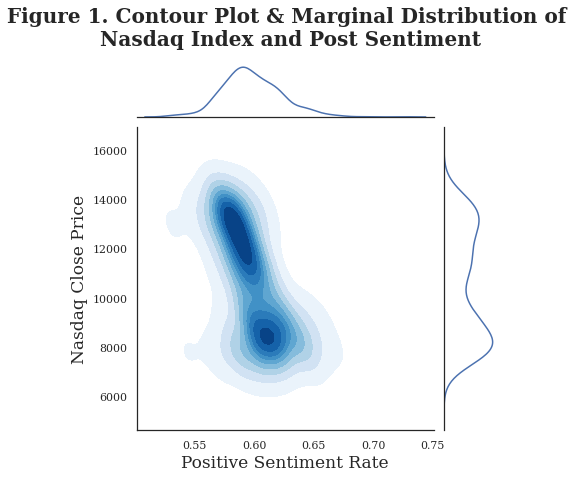

In [158]:
## Plot the figure
plt.figure(figsize=(12,10)) ## Fig size
sns.set_style("white") ## Set a style
pal = sns.color_palette(palette="coolwarm", n_colors=2)[1::-1] ## Generate a color_palette
plt.rcParams.update({'font.family':'serif'}) ## Set a font family

### Make the plot
#ax = sns.pairplot(df_sent_date[["pos", "close", "volume"]], kind='reg', palette=pal[1])
sns.jointplot(x=df_sent_date["Positive Sentiment Rate"], y=df_sent_date["Nasdaq Close Price"], cmap="Blues", shade=True, kind='kde')

### Set title, axis labels and legend
plt.title(label = "Figure 1. Contour Plot & Marginal Distribution of \nNasdaq Index and Post Sentiment", fontsize = 20, fontweight = "bold", y = 1.25, x = -3)
plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)
plt.rc('axes', titlesize=15, labelsize=17)

plt.show()

### 5.2 Radar Plot

In [246]:
df_sent_flair = df_sentiment.groupBy("author_flair_text").pivot('sentiment').count().toPandas()
df_sent_flair = df_sent_flair[df_sent_flair.positive > 10000].reset_index(drop=True)
df_sent_flair["pos_rate"] = df_sent_flair.positive / (df_sent_flair.negative + df_sent_flair.neutral + df_sent_flair.positive)

In [247]:
# Bars are sorted by the cumulative track length
df_sent_flair_sorted = df_sent_flair.sort_values("pos_rate", ascending=False).reset_index(drop=True)

# Values for the x axis
ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(df_sent_flair_sorted), endpoint=False)

# Cumulative length
LENGTHS = df_sent_flair_sorted["pos_rate"].values

# Author label
REGION = df_sent_flair_sorted["author_flair_text"].values

# Group of Positive
df_sent_flair_sorted['n'] = pd.DataFrame([1 if i<=2 else 2 if i<=5 else 3 if i<=8 else 4 for i in df_sent_flair_sorted.index])

TRACKS_N = df_sent_flair_sorted["n"].values

In [248]:
import matplotlib as mpl

GREY12 = "#1f1f1f"

# The minus glyph is not available in Bell MT
# This disables it, and uses a hyphen
plt.rc("axes", unicode_minus=False)

# Colors
COLORS = ["#6C5B7B","#C06C84","#F67280","#F8B195"]

# Colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list("my color", COLORS, N=256)

# Normalizer
norm = mpl.colors.Normalize(vmin=TRACKS_N.min(), vmax=TRACKS_N.max())

# Normalized colors. Each number of tracks is mapped to a color in the 
# color scale 'cmap'
COLORS = cmap(norm(TRACKS_N))

Text(0.5, 1.0, 'Figure 2. Radar Plot of Positive Sentiment Rate \nfor Different Author Flair Type')

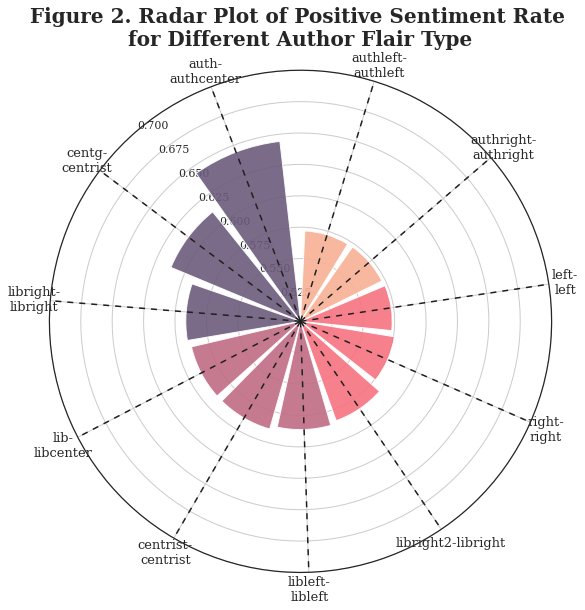

In [253]:
from textwrap import wrap

fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

# Set background color to white, both axis and figure.
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(bottom=0.5, top=0.7)

# Add geometries to the plot
# Add bars to represent the cumulative track lengths
ax.bar(x = ANGLES, height=LENGTHS-0.5, bottom=0.5, 
       color=COLORS, alpha=0.9, width=0.5, zorder=11)

# Add dashed vertical lines. These are just references
ax.vlines(ANGLES, 0.5, 0.7, color=GREY12, ls=(0, (4, 4)), zorder=12)

# Add labels for the regions
REGION = ["\n".join(wrap(r, 5, break_long_words=False)) for r in REGION]
#REGION

# Set the labels
ax.set_xticks(ANGLES)
ax.set_xticklabels(REGION, size=13);

ax.set_title(label = "Figure 2. Radar Plot of Positive Sentiment Rate \nfor Different Author Flair Type", fontsize = 20, fontweight = "bold")

### 5.3 Boxenplot

In [254]:
df_sent_score = df_sentiment.select("score", "sentiment").sample(fraction=0.005, seed=502).toPandas()

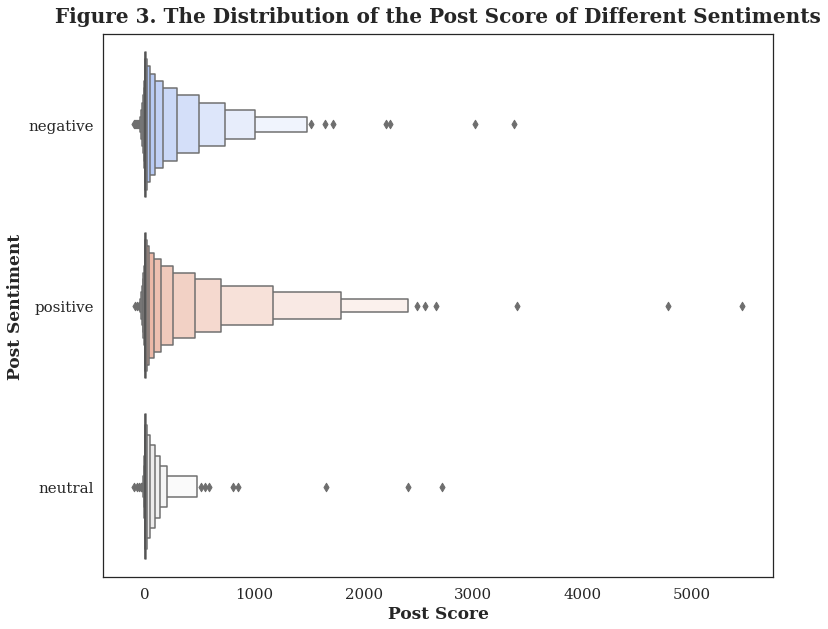

In [255]:
plt.figure(figsize=(12,10))
pal = [sns.color_palette(palette="coolwarm", n_colors=3)[0], 
       sns.color_palette(palette="coolwarm", n_colors=3)[2], 
       sns.color_palette(palette="coolwarm", n_colors=3)[1]]
sns.set(style = "white") ## Set a style
plt.rcParams.update({'font.family':'serif'})

sns.boxenplot(x="score", y="sentiment", palette=pal, scale="linear", data=df_sent_score, orient="h")

### Set a title, axis label, legend and rotate the xticks
plt.title(label="Figure 3. The Distribution of the Post Score of Different Sentiments", fontsize = 20, fontweight = "bold", y = 1.01)
plt.xlabel(xlabel = "Post Score", fontsize = 17, fontweight = "bold")
plt.ylabel(ylabel = "Post Sentiment", fontsize = 17, fontweight = "bold")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()

## 6. Summary Tables
1. After the explosion of COVID, the proportion of negative posts also started to increase. 
2. `COVID` and `Racial Equality` related posts tend to have a larger proportion of negative sentiment, while `Economics` and `Gender Equality` related posts are likely to be more positive. 

In [266]:
summary_1 = df_sentiment.groupBy("month").pivot('sentiment').count().toPandas()

In [267]:
summary_1["Negative Rate"] = summary_1.negative / (summary_1.negative + summary_1.neutral + summary_1.positive)
summary_1["Neutral Rate"] = summary_1.neutral / (summary_1.negative + summary_1.neutral + summary_1.positive)
summary_1["Positive Sentiment Rate"] = summary_1.positive / (summary_1.negative + summary_1.neutral + summary_1.positive)
summary_1.sort_values(by = "month", inplace=True)
summary_1.reset_index(drop = True, inplace = True)

In [268]:
summary_1

,month,negative,neutral,positive,Negative Rate,Neutral Rate,Positive Sentiment Rate
0,2019-07,2975,440,5597,0.330115,0.048824,0.621061
1,2019-08,4511,637,7821,0.347829,0.049117,0.603053
2,2019-09,5745,825,9875,0.349346,0.050167,0.600486
3,2019-10,11570,1844,21039,0.335820,0.053522,0.610658
4,2019-11,16838,2521,31686,0.329866,0.049388,0.620746
5,2019-12,29962,4754,57539,0.324774,0.051531,0.623695
6,2020-01,49450,7678,95539,0.323908,0.050292,0.625800
7,2020-02,53250,8385,104252,0.321002,0.050546,0.628452
8,2020-03,88029,12979,154286,0.344814,0.050839,0.604346
9,2020-04,130314,18905,227494,0.345924,0.050184,0.603892


In [270]:
summary_2 = df_sentiment.groupBy("sentiment").agg(f.sum("covid"), 
                                                  f.sum("election"), 
                                                  f.sum("economics"), 
                                                  f.sum("finance"), 
                                                  f.sum("gender_equality"),
                                                 f.sum("racial_equality")).toPandas()

In [272]:
summary_2 = summary_2.rename(columns = {"sum(covid)":"covid",
                                        "sum(election)":"election", 
                                        "sum(economics)":"economics", 
                                        "sum(finance)":"finance", 
                                        "sum(gender_equality)":"gender_equality",
                                        "sum(racial_equality)":"racial_equality"})

In [273]:
summary_2

,sentiment,covid,election,economics,finance,gender_equality,racial_equality
0,positive,12548,20562,62773,13928,43667,98744
1,neutral,1813,2516,4979,1517,2021,15071
2,negative,20020,21120,52316,13579,14229,157961


## 7. Save the Data
### Answer:
The data containing clean text, sentiment and new dummy variables are saved to S3 bucket.

In [73]:
df_sentiment.write.parquet("s3://yc910-labdata-3/reddit_nlp", mode="overwrite")

In [274]:
spark.stop()